### There are several ways to establish connection to local postgresql db but we will use pandas and sqlalchemy libraries

### To install it RUN THE NEXT CELL BY CLICKING ON IT AND SHIFT+ENTER or click RUN BUTTON ABOVE

In [12]:
!pip install pandas sqlalchemy
!pip install psycopg2-binary


  Obtaining dependency information for psycopg2-binary from https://files.pythonhosted.org/packages/61/69/3b3d7bd583c6d3cbe5100802efa5beacaacc86e37b653fc708bf3d6853b8/psycopg2_binary-2.9.10-cp311-cp311-win_amd64.whl.metadata
   ---------------------------------------- 0.0/1.2 MB ? eta -:--:--
   - -------------------------------------- 0.0/1.2 MB 653.6 kB/s eta 0:00:02
   ----- ---------------------------------- 0.2/1.2 MB 1.5 MB/s eta 0:00:01
   ------------- -------------------------- 0.4/1.2 MB 2.6 MB/s eta 0:00:01
   ------------------------ --------------- 0.7/1.2 MB 3.8 MB/s eta 0:00:01
   ----------------------------- ---------- 0.9/1.2 MB 3.7 MB/s eta 0:00:01
   ---------------------------------------- 1.2/1.2 MB 4.1 MB/s eta 0:00:00


### As now we have proper libraries we can import and use them 

### Execute the following cell 

In [13]:
import pandas as pd
from sqlalchemy import create_engine

def connect_to_db(dbname: str, user: str, password: str, host: str = "localhost", port: str = "5432"):
    try:
        conn_str = f"postgresql://{user}:{password}@{host}:{port}/{dbname}"
        engine = create_engine(conn_str)
        print(f"Engine created for database: {dbname}")
        return engine
    except Exception as e:
        print(f"Error creating engine for {dbname}: {e}")
        return None


### in previous cell we creted connect_to_db function which we can reuse to connect to both of our DBs, we just need to provide propper attributers. 

### In the next cell you can find example of establishing connection to SRC DB and reading data from s1.s1_channels into separate pandas dataframe

### Execute the following cell 

In [16]:
src_engine = connect_to_db(
    dbname="dwh_src_hw_db",
    user="postgres",
    password="CretuPaul1990."
)
s1_channels_df = pd.read_sql("SELECT * FROM s1.s1_channels", src_engine)
s1_channels_df

Engine created for database: dwh_src_hw_db


channel_id        channel_name        channel_location
0            1           STORE - 1        621 Hovde Circle
1            2           STORE - 2  9459 Trailsway Terrace
2            3           STORE - 3     23 Transport Street
3            4           STORE - 4            7 Pond Place
4            5           STORE - 5   6799 Armistice Avenue
..         ...                 ...                     ...
153        154          YAOBAO.COM                Internet
154        155  CATALOG.ONLINER.BY                Internet
155        156         5ELEMENT.BY                Internet
156        157          ALLEGRO.PL                Internet
157        158          AMAZON.COM                Internet

[158 rows x 3 columns]

 ## YOUR TASK IS TO ESTABLISH SEPARATE 

 trg_engine 

 ## and conect to dwh_hw_db in the next cell

In [18]:
trg_engine = connect_to_db(
    dbname="dwh_hw_db",
    user="postgres",
    password="CretuPaul1990."
)
lnd_s1_channels_df = pd.read_sql("SELECT * FROM lnd.lnd_s1_channels", trg_engine)
lnd_s1_channels_df

Engine created for database: dwh_hw_db


channel_id        channel_name        channel_location
0            1           STORE - 1        621 Hovde Circle
1            2           STORE - 2  9459 Trailsway Terrace
2            3           STORE - 3     23 Transport Street
3            4           STORE - 4            7 Pond Place
4            5           STORE - 5   6799 Armistice Avenue
..         ...                 ...                     ...
151        152            EBAY.COM          N/A - Internet
152        153      ALIEXPRESS.COM          N/A - Internet
153        154          YAOBAO.COM          N/A - Internet
154        155  CATALOG-ONLINER.BY          N/A - Internet
155        156         5ELEMENT.BY          N/A - Internet

[156 rows x 3 columns]

#### AS we have 2 DFs with data from 2 tables we need to compare them. To do so we can create separate DF s1_channels_comparison_df

### Execute the following cell 

In [19]:
s1_channels_comparison_df = s1_channels_df.merge(
    lnd_s1_channels_df,
    on='channel_id',
    how='outer',
    suffixes=('_src', '_lnd'),
    indicator=True  
)
s1_channels_comparison_df

channel_id channel_name_src       channel_location_src channel_name_lnd  \
0            1        STORE - 1           621 Hovde Circle        STORE - 1   
1           10       STORE - 10  6840 Pennsylvania Terrace       STORE - 10   
2          100      STORE - 100        72760 Helena Avenue      STORE - 100   
3          101      STORE - 101             40 Lyons Place      STORE - 101   
4          102      STORE - 102          04 Ludington Pass      STORE - 102   
..         ...              ...                        ...              ...   
153         95       STORE - 95         6354 Lukken Circle       STORE - 95   
154         96       STORE - 96       1 Lighthouse Bay Way       STORE - 96   
155         97       STORE - 97          03 Moland Parkway       STORE - 97   
156         98       STORE - 98           24450 Kim Center       STORE - 98   
157         99       STORE - 99           28956 Emmet Hill       STORE - 99   

          channel_location_lnd _merge  
0             621 Hovde Circle   both  
1    6840 Pennsylvania Terrace   both  
2          72760 Helena Avenue   both  
3               40 Lyons Place   both  
4            04 Ludington Pass   both  
..                         ...    ...  
153         6354 Lukken Circle   both  
154       1 Lighthouse Bay Way   both  
155          03 Moland Parkway   both  
156           24450 Kim Center   both  
157           28956 Emmet Hill   both  

[158 rows x 6 columns]

### Since we use indicator=True in the merge, pandas automatically provides the _merge column with values left_only, right_only, or both for the ID values.

### However, we want to make the statuses more meaningful, similar to what we did in SQL and also check for differences in other attributes, not just IDs.
### For this reason, I have prepared a separate function specifically for computing reconciliation_status for the channels table.

### Execute the following cell 

In [24]:
def get_s1_channels_reconciliation_status(row):
    if row['_merge'] == 'left_only':
        return 'Only in source'
    elif row['_merge'] == 'right_only':
        return 'Only in landing'
    
    mismatches = []
    if row['channel_name_src'] != row['channel_name_lnd']:
        mismatches.append('channel_name')
    if row['channel_location_src'] != row['channel_location_lnd']:
        mismatches.append('channel_location')
    
    if mismatches:
        return 'Mismatch in ' + ', '.join(mismatches)
    
    return 'Match'


### Since this function expects a single row as input, we can apply it to our s1_channel_comparison_df and create a new column to store the adapted reconciliation statuses.

### Execute the following cell 


In [27]:
s1_channels_comparison_df['reconciliation_status'] = s1_channels_comparison_df.apply(get_s1_channels_reconciliation_status, axis=1)

### And now, let’s keep only the rows with discrepancies (i.e., excluding rows where everything matches).

In [28]:
s1_channels_issues_df = s1_channels_comparison_df[s1_channels_comparison_df['reconciliation_status'] != 'Match']
print(s1_channels_issues_df.head(20))

   channel_id    channel_name_src channel_location_src    channel_name_lnd  \
58        151          AMAZON.COM             Internet          AMAZON.COM   
59        152            EBAY.COM             Internet            EBAY.COM   
60        153      ALIEXPRESS.COM             Internet      ALIEXPRESS.COM   
61        154          YAOBAO.COM             Internet          YAOBAO.COM   
62        155  CATALOG.ONLINER.BY             Internet  CATALOG-ONLINER.BY   
63        156         5ELEMENT.BY             Internet         5ELEMENT.BY   
64        157          ALLEGRO.PL             Internet                 NaN   
65        158          AMAZON.COM             Internet                 NaN   

   channel_location_lnd     _merge                       reconciliation_status  
58       N/A - Internet       both                Mismatch in channel_location  
59       N/A - Internet       both                Mismatch in channel_location  
60       N/A - Internet       both                Mism

# Task: Reconcile all other table pairs from SRC and LND, similar to what we did for the channels table.

## Instructions:

### Tables to compare:

###### s1.s1_products → lnd.lnd_s1_products
###### s1.s1_sales → lnd.lnd_s1_sales
###### s2.s2_channels → lnd.lnd_s2_channels
###### s2.s2_client_sales → lnd.lnd_s2_client_sales
###### s2.s2_clients → lnd.lnd_s2_clients
###### s2.s2_locations → lnd.lnd_s2_locations

## For each table pair:

### 1. Load the SRC and LND tables into pandas DataFrames.
### 2. Perform a full outer merge on the primary key column(s).
### 3. Apply a function like get_reconciliation_status(row) to classify each row into statuses:
###### 'Only in source'
###### 'Only in landing'
###### 'Mismatch in <column_name>'
###### 'Match'

### Keep only rows with issues (statuses != 'Match').

## 4. Create a consolidated result DataFrame with the following columns:

###### table_name	Name of the table being compared
###### key_column	Primary key column used for reconciliation
###### src_id	ID value from source table
###### trg_id	ID value from landing table
###### reconciliation_status	Status of the row (Only in source, Only in landing, etc.)

## 5. Populate the final result DataFrame with all discrepancies from all table comparisons.

### Tips / Methods:

### Use pd.merge(..., how='outer', indicator=True) to combine SRC and LND tables.
### Apply your reconciliation status function row-wise with df.apply(..., axis=1).
### Filter only rows with issues using df[df['reconciliation_status'] != 'Match'].
### Concatenate multiple issues_df DataFrames using pd.concat([...], ignore_index=True) to create the final consolidated DataFrame.

In [40]:

# ============================================================
# STEP 1: CONNECT TO SOURCE DATABASE (src_engine)
# ------------------------------------------------------------
# We first connect to the **source database** (dwh_src_hw_db).
# This database contains the raw source tables from schemas:
#   - s1.*
#   - s2.*
#
# These will be compared later against the landing tables.
# ============================================================

src_engine = connect_to_db(
    dbname="dwh_src_hw_db",   # Source database
    user="postgres",          # User for authentication
    password="CretuPaul1990." # Password for authentication
)


# ============================================================
# STEP 2: FETCH SOURCE TABLES (S1 schema)
# ------------------------------------------------------------
# Extract all S1 schema tables into pandas DataFrames:
#   - s1_channels
#   - s1_clients
#   - s1_sales
#   - s1_products
#
# Each DataFrame is printed so we can visually inspect the data.
# ============================================================

s1_channels_df = pd.read_sql("SELECT * FROM s1.s1_channels", src_engine)
print(s1_channels_df)

s1_clients_df = pd.read_sql("SELECT * FROM s1.s1_clients", src_engine)
print(s1_clients_df)

s1_sales_df = pd.read_sql("SELECT * FROM s1.s1_sales", src_engine)
print(s1_sales_df)

s1_products_df = pd.read_sql("SELECT * FROM s1.s1_products", src_engine)
print(s1_products_df)


# ============================================================
# STEP 3: FETCH SOURCE TABLES (S2 schema)
# ------------------------------------------------------------
# Extract all S2 schema tables into pandas DataFrames:
#   - s2_channels
#   - s2_clients
#   - s2_client_sales
#   - s2_locations
#
# Again, each DataFrame is printed for inspection.
# ============================================================

s2_channels_df = pd.read_sql("SELECT * FROM s2.s2_channels", src_engine)
print(s2_channels_df)

s2_clients_df = pd.read_sql("SELECT * FROM s2.s2_clients", src_engine)
print(s2_clients_df)

s2_client_sales_df = pd.read_sql("SELECT * FROM s2.s2_client_sales", src_engine)
print(s2_client_sales_df)

s2_locations_df = pd.read_sql("SELECT * FROM s2.s2_locations", src_engine)
print(s2_locations_df)


# ============================================================
# STEP 4: CONNECT TO TARGET DATABASE (trg_engine)
# ------------------------------------------------------------
# Now we connect to the **target database** (dwh_hw_db).
# This contains the landing schema (lnd.*), which stores data
# after it has been loaded into the Data Warehouse.
#
# These landing tables will be compared against the source
# tables extracted above.
# ============================================================

trg_engine = connect_to_db(
    dbname="dwh_hw_db",       # Target database
    user="postgres",          # User for authentication
    password="CretuPaul1990." # Password for authentication
)


# ============================================================
# STEP 5: FETCH LANDING TABLES (LND schema)
# ------------------------------------------------------------
# Extract all lnd schema tables into pandas DataFrames:
#
# Landing equivalents of S1 tables:
#   - lnd_s1_channels
#   - lnd_s1_clients
#   - lnd_s1_sales
#   - lnd_s1_products
#
# Landing equivalents of S2 tables:
#   - lnd_s2_channels
#   - lnd_s2_clients
#   - lnd_s2_client_sales
#   - lnd_s2_locations
#
# These will later be reconciled against the source DataFrames.
# ============================================================

lnd_s1_channels_df = pd.read_sql("SELECT * FROM lnd.lnd_s1_channels", trg_engine)
print(lnd_s1_channels_df)

lnd_s1_clients_df = pd.read_sql("SELECT * FROM lnd.lnd_s1_clients", trg_engine)
print(lnd_s1_clients_df)

lnd_s1_sales_df = pd.read_sql("SELECT * FROM lnd.lnd_s1_sales", trg_engine)
print(lnd_s1_sales_df)

lnd_s1_products_df = pd.read_sql("SELECT * FROM lnd.lnd_s1_products", trg_engine)
print(lnd_s1_products_df)

lnd_s2_channels_df = pd.read_sql("SELECT * FROM lnd.lnd_s2_channels", trg_engine)
print(lnd_s2_channels_df)

lnd_s2_clients_df = pd.read_sql("SELECT * FROM lnd.lnd_s2_clients", trg_engine)
print(lnd_s2_clients_df)

lnd_s2_client_sales_df = pd.read_sql("SELECT * FROM lnd.lnd_s2_client_sales", trg_engine)
print(lnd_s2_client_sales_df)

lnd_s2_locations_df = pd.read_sql("SELECT * FROM lnd.lnd_s2_locations", trg_engine)
print(lnd_s2_locations_df)
# ============================================================
# STEP 6: DEFINE FUNCTION TO COMPARE TABLES
# ------------------------------------------------------------
# The function `compare_tables` compares two DataFrames
# (source vs landing) based on a set of join keys.
#
# It performs an **outer join** so we can detect:
#   - Records only in source
#   - Records only in landing
#   - Records present in both
#
# It returns a DataFrame with a special `_merge` column that
# indicates where each row came from.
# ============================================================

def compare_tables(df_src: pd.DataFrame, df_lnd: pd.DataFrame, table_name: str, join_keys: list[str]) -> pd.DataFrame:
    """
    Compare two DataFrames on given join keys.
    """
    # Validate that join keys exist in both DataFrames
    for key in join_keys:
        if key not in df_src.columns or key not in df_lnd.columns:
            raise KeyError(f"Join key '{key}' not found in both DataFrames for {table_name}")

    # Perform outer join with indicator
    comparison_df = df_src.merge(
        df_lnd,
        on=join_keys,
        how="outer",
        suffixes=("_src", "_lnd"),
        indicator=True
    )
    return comparison_df


# ============================================================
# STEP 7: DEFINE JOIN KEYS PER TABLE
# ------------------------------------------------------------
# Each table needs a "grain" (unique key columns).
# These join keys are required to match source rows with
# landing rows correctly.
# ============================================================

join_key_map = {
    "channels": ["channel_id"],
    "clients": ["client_id"],
    "products": ["product_id"],
    "sales": ["client_id", "channel_id", "sale_date", "product_id"],        # Fact table (grain)
    "channels_s2": ["channel_id"],
    "clients_s2": ["client_id"],
    "client_sales": ["client_id", "channel_id", "saled_at", "product_id"],  # Fact with timestamp
    "locations": ["location_id"],
}


# ============================================================
# STEP 8: RUN COMPARISONS (SOURCE vs LANDING)
# ------------------------------------------------------------
# Build a dictionary of table pairs (source, landing).
# For each pair:
#   - Run `compare_tables`
#   - Count how many rows match / only in source / only in landing
#   - Print summary
# ============================================================

table_pairs = {
    "channels": (s1_channels_df, lnd_s1_channels_df),
    "clients": (s1_clients_df, lnd_s1_clients_df),
    "sales": (s1_sales_df, lnd_s1_sales_df),
    "products": (s1_products_df, lnd_s1_products_df),
    "channels_s2": (s2_channels_df, lnd_s2_channels_df),
    "clients_s2": (s2_clients_df, lnd_s2_clients_df),
    "client_sales": (s2_client_sales_df, lnd_s2_client_sales_df),
    "locations": (s2_locations_df, lnd_s2_locations_df),
}

comparisons = {}

for name, (df_src, df_lnd) in table_pairs.items():
    try:
        comparisons[name] = compare_tables(df_src, df_lnd, name, join_key_map[name])
        summary = comparisons[name]["_merge"].value_counts().to_dict()
        print(f"✅ Compared {name}, shape = {comparisons[name].shape}, summary = {summary}")
    except Exception as e:
        print(f"⚠️ Could not compare {name}: {e}")


# ============================================================
# STEP 9: DEFINE FUNCTION TO RECONCILE TABLES
# ------------------------------------------------------------
# While `compare_tables` only flags presence/absence,
# the function `reconcile_tables` does a **deeper check**.
#
# It:
#   - Joins source and landing by keys
#   - Checks if column values match
#   - Flags rows as:
#       * Only in source
#       * Only in landing
#       * Mismatched column(s)
#       * Match
#
# Returns a clean reconciliation report with:
#   [table_name, key_column, src_id, trg_id, reconciliation_status]
# ============================================================

def reconcile_tables(df_src: pd.DataFrame, df_lnd: pd.DataFrame, table_name: str,
                     key_cols: list[str], compare_cols: list[str]) -> pd.DataFrame:
    """
    General reconciliation function for any table.
    """
    # Outer join to capture all differences
    merged = df_src.merge(
        df_lnd,
        how='outer',
        on=key_cols,
        suffixes=('_src', '_lnd'),
        indicator=True
    )

    # Row-level reconciliation logic
    def row_status(row):
        if row['_merge'] == 'left_only':
            return 'Only in source'
        elif row['_merge'] == 'right_only':
            return 'Only in landing'

        mismatches = []
        for col in compare_cols:
            src_col = f"{col}_src"
            lnd_col = f"{col}_lnd"
            if pd.isna(row[src_col]) and pd.isna(row[lnd_col]):
                continue
            elif row[src_col] != row[lnd_col]:
                mismatches.append(col)

        if mismatches:
            return 'Mismatch in ' + ', '.join(mismatches)
        return 'Match'

    merged['reconciliation_status'] = merged.apply(row_status, axis=1)
    merged['table_name'] = table_name
    merged['key_column'] = ', '.join(key_cols)

    # Build src_id and trg_id for traceability
    if key_cols:
        merged['src_id'] = merged.apply(
            lambda row: '|'.join(row[key_cols].fillna('').astype(str))
            if row['_merge'] != 'right_only' else None,
            axis=1
        )
        merged['trg_id'] = merged.apply(
            lambda row: '|'.join(row[key_cols].fillna('').astype(str))
            if row['_merge'] != 'left_only' else None,
            axis=1
        )
    else:
        merged['src_id'] = None
        merged['trg_id'] = None

    # Keep only mismatches or missing rows
    display_cols = ['table_name', 'key_column', 'src_id', 'trg_id', 'reconciliation_status']
    issues_df = merged[merged['reconciliation_status'] != 'Match'].copy()
    return issues_df[display_cols]


# ============================================================
# STEP 10: DEFINE RECONCILIATION SETTINGS
# ------------------------------------------------------------
# For each table, specify:
#   - Source DataFrame
#   - Landing DataFrame
#   - Table name (for reporting)
#   - Key columns (unique grain)
#   - Columns to compare for mismatches
# ============================================================

reconcile_settings = [
    # Dimension and fact tables S1
    (s1_channels_df, lnd_s1_channels_df, 's1_channels', ['channel_id'], ['channel_name', 'channel_location']),
    (s1_clients_df, lnd_s1_clients_df, 's1_clients', ['client_id'], ['first_name', 'middle_name', 'last_name', 'email', 'phone', 'first_purchase']),
    (s1_products_df, lnd_s1_products_df, 's1_products', ['product_id'], ['product_name', 'cost']),
    (s1_sales_df, lnd_s1_sales_df, 's1_sales', ['client_id', 'channel_id', 'product_id', 'sale_date'], ['units', 'purchase_date']),

    # Dimension and fact tables S2
    (s2_channels_df, lnd_s2_channels_df, 's2_channels', ['channel_id'], ['channel_name', 'location_id']),
    (s2_locations_df, lnd_s2_locations_df, 's2_locations', ['location_id'], ['location_name']),
    (s2_clients_df, lnd_s2_clients_df, 's2_clients', ['client_id'], ['first_name', 'last_name', 'email', 'phone_code', 'phone_number', 'first_purchase', 'valid_from', 'valid_to']),
    (s2_client_sales_df, lnd_s2_client_sales_df, 's2_client_sales', ['client_id', 'channel_id', 'product_id', 'saled_at'], ['product_name', 'product_price', 'product_amount', 'sold_date'])
]


# ============================================================
# STEP 11: RUN RECONCILIATION FOR ALL TABLES
# ------------------------------------------------------------
# - Apply `reconcile_tables` to each table defined above
# - Combine all mismatches into one DataFrame
# ============================================================

all_issues = pd.concat([
    reconcile_tables(src, lnd, name, key_cols, compare_cols)
    for src, lnd, name, key_cols, compare_cols in reconcile_settings
], ignore_index=True)


# ============================================================
# STEP 12: AGGREGATE & REPORT ISSUES
# ------------------------------------------------------------
# - Count mismatches per table
# - Show first 20 issues
# - Print total number of issues
# ============================================================

python_counts = all_issues.groupby("table_name").size().reset_index(name="python_count")

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)
pd.set_option('display.max_colwidth', None)

print(all_issues.head(20))
print(f"Total issues found: {len(all_issues)}")
print(python_counts)
# ============================================================
# STEP 13: SUMMARY REPORTING FUNCTION
# ------------------------------------------------------------
# This function summarizes reconciliation results in a clean,
# human-readable format.
#
# For each table it shows:
#   - Total number of issues
#   - Breakdown by type:
#       * Only in source
#       * Only in landing
#       * Mismatches
#
# Tables with zero issues get a ✅ mark.
# ============================================================

def print_reconciliation_summary(all_issues: pd.DataFrame):
    if all_issues.empty:
        print("🎉 No issues found across all tables! All good.")
        return

    summary = (
        all_issues
        .groupby(["table_name", "reconciliation_status"])
        .size()
        .reset_index(name="count")
    )

    for table in summary["table_name"].unique():
        table_summary = summary[summary["table_name"] == table]
        total_issues = table_summary["count"].sum()

        if total_issues == 0:
            print(f"✅ {table}: no issues found")
            continue

        print(f"\n❌ {table}: {total_issues} issues found")
        for _, row in table_summary.iterrows():
            print(f"   - {row['reconciliation_status']}: {row['count']}")


# ============================================================
# STEP 14: CALL SUMMARY FUNCTION
# ============================================================

print_reconciliation_summary(all_issues)


Engine created for database: dwh_src_hw_db
    channel_id        channel_name        channel_location
0            1           STORE - 1        621 Hovde Circle
1            2           STORE - 2  9459 Trailsway Terrace
2            3           STORE - 3     23 Transport Street
3            4           STORE - 4            7 Pond Place
4            5           STORE - 5   6799 Armistice Avenue
..         ...                 ...                     ...
153        154          YAOBAO.COM                Internet
154        155  CATALOG.ONLINER.BY                Internet
155        156         5ELEMENT.BY                Internet
156        157          ALLEGRO.PL                Internet
157        158          AMAZON.COM                Internet

[158 rows x 3 columns]
    client_id first_name middle_name  last_name                      email           phone first_purchase
0         484     Rickie       Hobie   Duckerin     hduckerindf@rambler.ru   +204994284442      22-JAN-00
1         485

## Optional task:

### based on the final result DataFrame build visualizatons 

### Total Anomalies per Table
### Reconciliation Summary by Table
### Reconciliation Status Distribution

## Examples are added

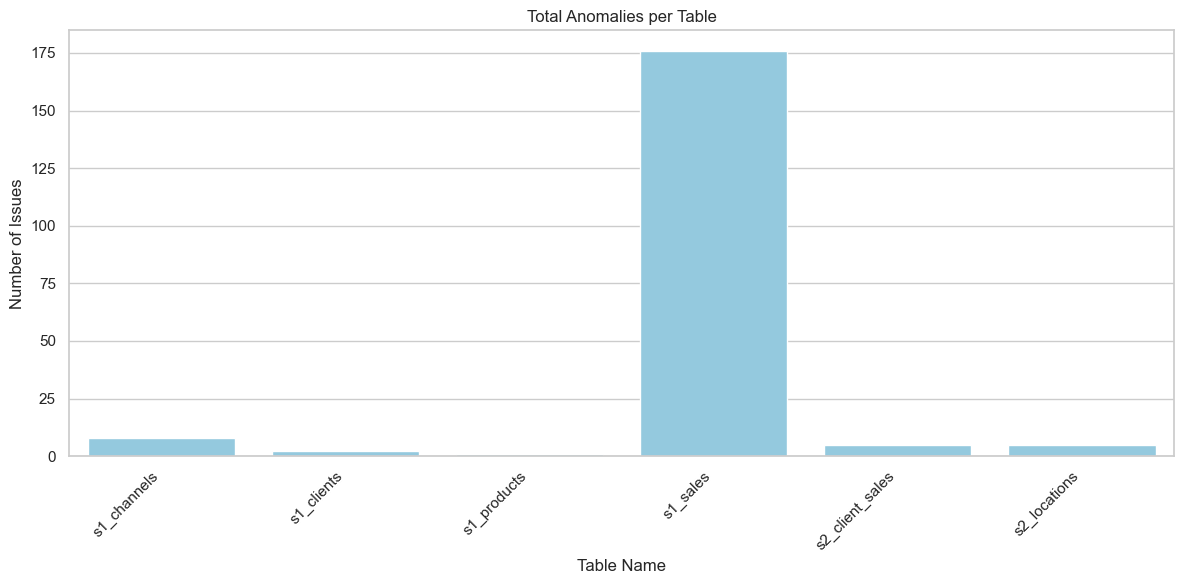

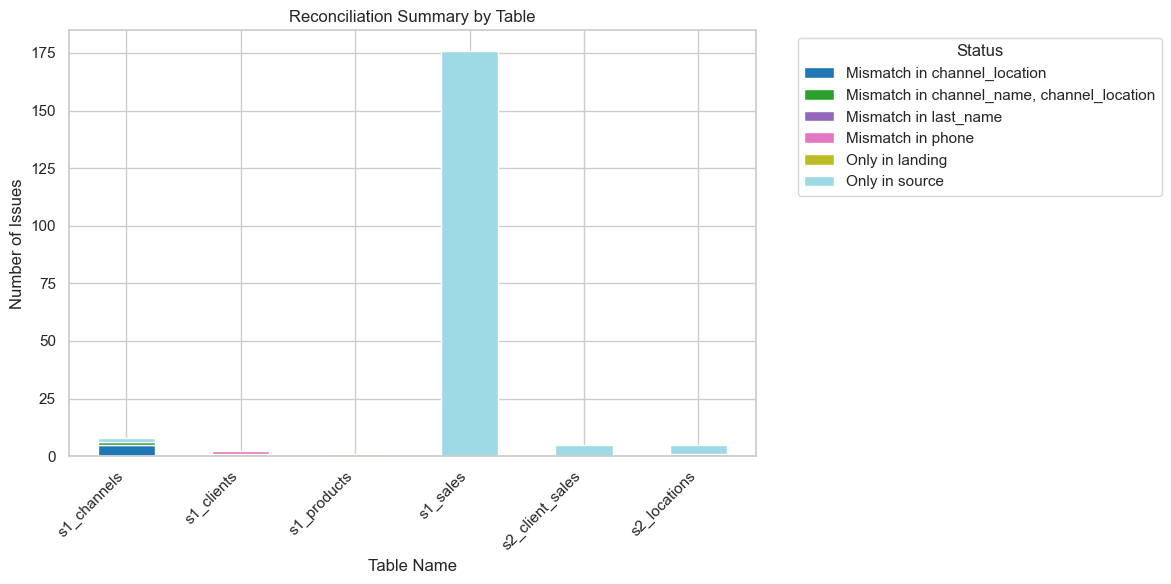

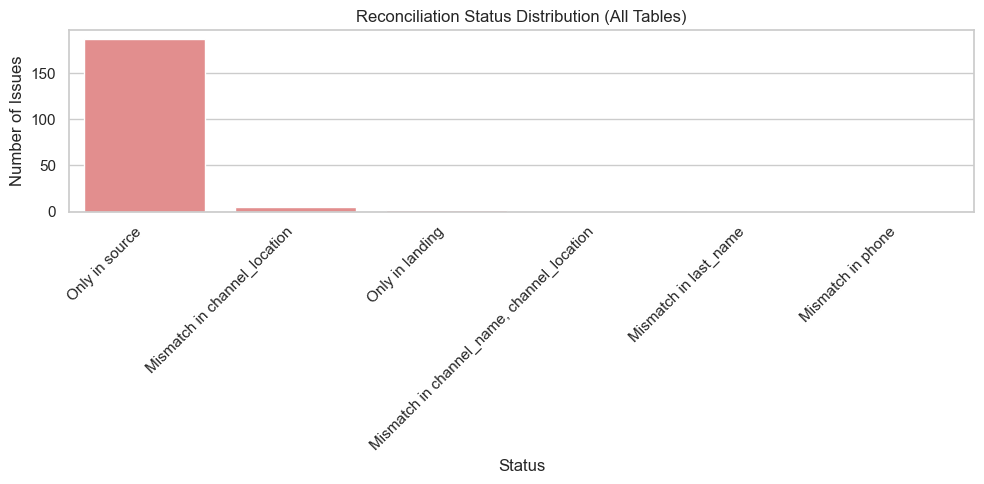

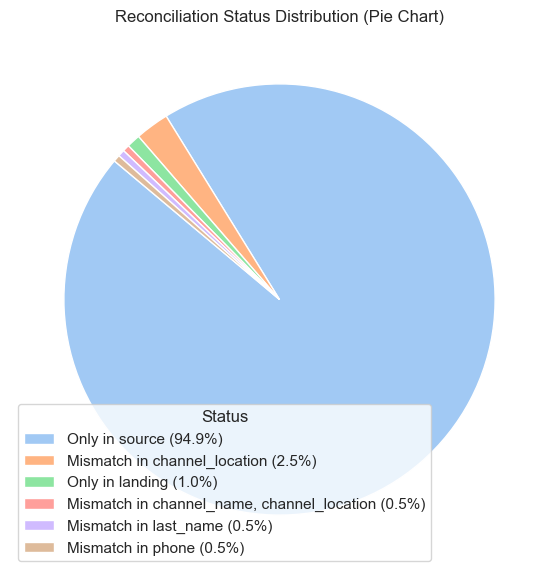

        table_name                       reconciliation_status  python_count
0      s1_channels                Mismatch in channel_location             5
1      s1_channels  Mismatch in channel_name, channel_location             1
2      s1_channels                              Only in source             2
3       s1_clients                       Mismatch in last_name             1
4       s1_clients                           Mismatch in phone             1
5      s1_products                             Only in landing             1
6         s1_sales                              Only in source           176
7  s2_client_sales                              Only in source             5
8     s2_locations                             Only in landing             1
9     s2_locations                              Only in source             4


In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

# ============================================================
# STEP 15: VISUALIZATION SETUP
# ------------------------------------------------------------
# We use matplotlib + seaborn to create summary plots
# for reconciliation results.
# - Seaborn adds nice styling
# - Matplotlib controls figure size and layout
# ============================================================

sns.set(style="whitegrid")       # clean background style
plt.rcParams['figure.figsize'] = (10,6)  # default figure size

# ============================================================
# STEP 16: TOTAL ANOMALIES PER TABLE (BAR CHART)
# ------------------------------------------------------------
# Count total number of issues found per table.
# ============================================================

issues_per_table = all_issues.groupby('table_name').size().reset_index(name='total_issues')

plt.figure(figsize=(12,6))
sns.barplot(data=issues_per_table, x='table_name', y='total_issues', color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.title('Total Anomalies per Table')
plt.ylabel('Number of Issues')
plt.xlabel('Table Name')
plt.tight_layout()
plt.show()


# ============================================================
# STEP 17: STACKED BAR (ISSUE TYPES PER TABLE)
# ------------------------------------------------------------
# Shows the breakdown of reconciliation statuses for each table.
# Example:
#   - Only in source
#   - Only in landing
#   - Mismatches
# ============================================================

summary_table = all_issues.groupby(['table_name', 'reconciliation_status']).size().reset_index(name='count')
summary_pivot = summary_table.pivot(index='table_name', columns='reconciliation_status', values='count').fillna(0)

summary_pivot.plot(kind='bar', stacked=True, figsize=(12,6), colormap='tab20')
plt.title('Reconciliation Summary by Table')
plt.ylabel('Number of Issues')
plt.xlabel('Table Name')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Status', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


# ============================================================
# STEP 18: STATUS DISTRIBUTION (BAR CHART)
# ------------------------------------------------------------
# Aggregate all issues across all tables and show how many
# fall into each reconciliation status category.
# ============================================================

status_dist = all_issues['reconciliation_status'].value_counts().reset_index()
status_dist.columns = ['reconciliation_status', 'count']

plt.figure(figsize=(10,5))
sns.barplot(data=status_dist, x='reconciliation_status', y='count', color='lightcoral')
plt.xticks(rotation=45, ha='right')
plt.title('Reconciliation Status Distribution (All Tables)')
plt.ylabel('Number of Issues')
plt.xlabel('Status')
plt.tight_layout()
plt.show()


# ============================================================
# STEP 19: STATUS DISTRIBUTION (PIE CHART)
# ------------------------------------------------------------
# Another view of reconciliation statuses, using a pie chart.
# Shows the proportion of:
#   - Only in source
#   - Only in landing
#   - Mismatches
# ============================================================

# Calculate percentages
total = status_dist['count'].sum()
percentages = (status_dist['count'] / total * 100).round(1)

plt.figure(figsize=(7,7))

# Plot pie chart (no labels inside)
wedges, texts, autotexts = plt.pie(
    status_dist['count'],
    autopct='',  # disable slice text to avoid clutter
    startangle=140,
    colors=sns.color_palette("pastel")
)

# Build legend labels with percentages
labels = [
    f"{cat} ({pct}%)" 
    for cat, pct in zip(status_dist['reconciliation_status'], percentages)
]

# Add legend
plt.legend(
    wedges,
    labels,
    title="Status",
    loc="best"
)

plt.title('Reconciliation Status Distribution (Pie Chart)')
plt.show()

# ============================================================
# STEP 20: PRINT GROUPED RECONCILIATION SUMMARY
# ------------------------------------------------------------
# Tabular breakdown: how many issues of each type per table.
# ============================================================

python_grouped = (
    all_issues
    .groupby(["table_name", "reconciliation_status"])
    .size()
    .reset_index(name="python_count")
)

print(python_grouped)
